# Unsupervised Analysis of Polycrystalline Graphene 

In this notebook, we demonstrate unsupervised strain analysis using polycrystalline graphene as an example. You will see that there is no sample specific parameters nor any parameters specific to graphene. Hence, this notebook can be modified for analysis of other samples with very little effort.

The analysis assumes that there are enough unperturbed lattice for use as reference.

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from psm import plotutils
from psm.build import lattice_traversal
from psm.geometry import transform
from psm.register import RMSD, MatchGraph
from psm.graph.geometric import urquhart
from psm.structures import traverse_from_all

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


D:\github\point-segment-matching\psm\register.py:17: UserWarning: Fast Cython subgraph isomorphism module unavailable.
  warnings.warn('Fast Cython subgraph isomorphism module unavailable.')


In [3]:
np.random.seed(13)

## Sample Structure
The sample points are imported and we build the geometric graph.

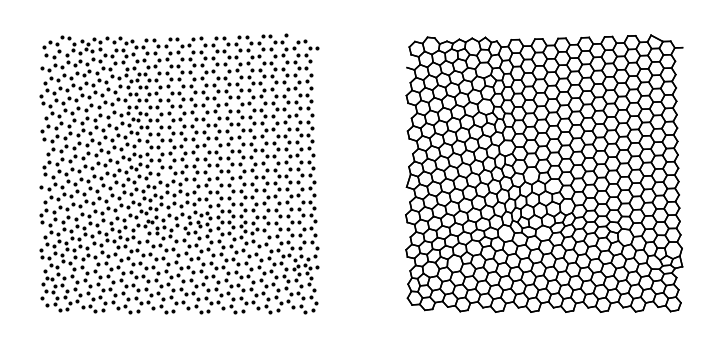

In [4]:
points = np.load('data/poly_graphene.npy')
adjacency = urquhart(points)

fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].plot(points[:,0], points[:,1], 'k.')
plotutils.graph_embedding(points, adjacency, ax = axes[1])
for ax in axes:
    ax.axis('equal')
    ax.axis('off')

We use clockwise graph traversals to extracts segments of 10 points from the larger sample. A sample of 10 of these sub-structures are shown.

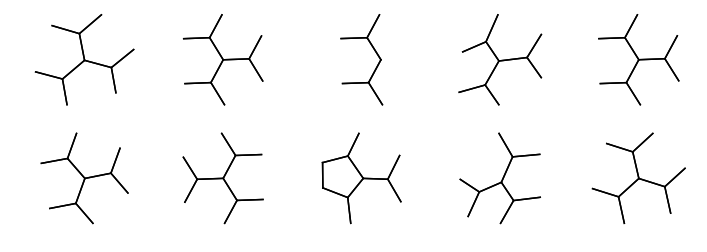

In [5]:
structures = traverse_from_all(points, adjacency, max_depth=3)

fig,axes = plt.subplots(2,5,figsize=(12,4))
plotutils.show_structures(structures.sample(.1), axes=axes.ravel())
for ax in axes.ravel():
    ax.axis('equal')
    ax.axis('off')

## Template structure
The clustering algorithm requires calculation of the pairwise RMSD between all segments, the time-complexity is thus $\mathcal{O}(N^2)$ with the number of segments $N$. To speed up the 


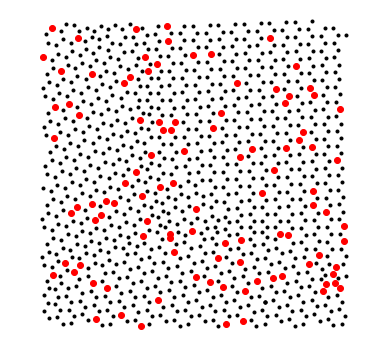

In [6]:
sample = structures.sample(.1)

fig,ax = plt.subplots(1, 1, figsize=(6,6))
ax.plot(structures.fronts[:,0], structures.fronts[:,1], 'k.')
ax.plot(sample.fronts[:,0], sample.fronts[:,1], 'ro')
ax.axis('equal')
ax.axis('off');

In [7]:
rmsd_calc = MatchGraph(transform='rigid', pivot='cop')
rmsd = rmsd_calc.register(sample, sample)

 [||||||||||||||||||||] 5253/5253 registrations


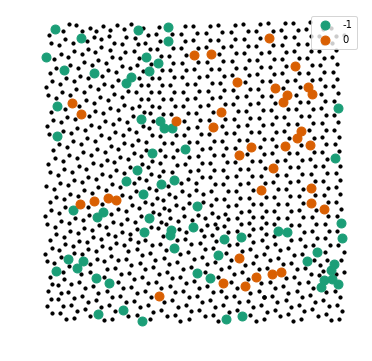

In [8]:
labels = rmsd_calc.cluster(.01, min_samples=10)

fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(structures.fronts[:,0], structures.fronts[:,1], c='k', s=10)

for label,color in zip(np.unique(labels), plt.cm.Dark2.colors):
    points = sample.fronts[label == labels]
    ax.scatter(points[:,0], points[:,1], c=color, s=80, label=label)

ax.legend()

ax.axis('equal')
ax.axis('off');

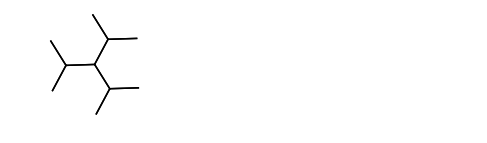

In [9]:
templates = rmsd_calc.principal_structures(1, .01, min_samples=10)

fig,axes = plt.subplots(1,3,figsize=(8,2))
plotutils.show_structures(templates, axes)
for ax in axes:
    ax.axis('equal')
    ax.axis('off');

## Pairing

In [10]:
rmsd_calc = RMSD(transform='similarity', scale_invariant=True, pivot='cop')
rmsd = rmsd_calc.register(templates, structures)

 [||||||||||||||||||||] 1031/1031 registrations


C:\Users\jacob\Anaconda3\envs\point-segment-matching\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: All-NaN slice encountered
  """Entry point for launching an IPython kernel.


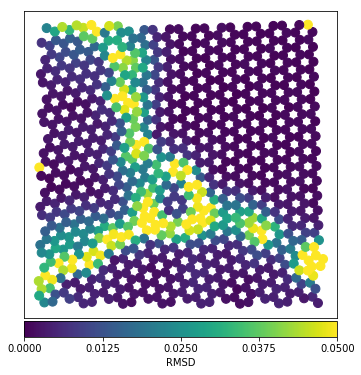

In [11]:
best_rmsd = np.nanmin(rmsd, axis=0)

fig,ax = plt.subplots(1,1,figsize=(6,6))
p = plt.scatter(structures.fronts[:,0], structures.fronts[:,1],
            c=best_rmsd, cmap='viridis', vmin=0, vmax=.05, s=80)

plotutils.add_colorbar(p, ax, 'bottom', label='RMSD', ticks=np.linspace(0,.05,5))

ax.axis('equal')
ax.set_xticks([])
ax.set_yticks([]);

## Strain

In [17]:
strain, rotation = rmsd_calc.calc_strain(structures)
strain = transform.zero_median(strain)

planar = transform.planar_strain(strain)
shear = strain[:,0,1]
rotation = (rotation % (np.pi/3)) / np.pi * 180

C:\Users\jacob\Anaconda3\envs\point-segment-matching\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in remainder
  


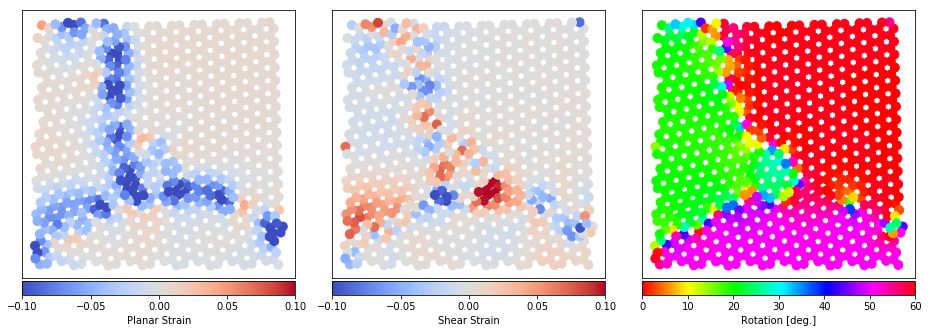

In [19]:
fig,axes = plt.subplots(1, 3, figsize=(13,6))

p = axes[0].scatter(structures.fronts[:,0], structures.fronts[:,1],
                c=planar, cmap='coolwarm', vmin=-.1, vmax=.1, s=80)
plotutils.add_colorbar(p, axes[0], 'bottom', label='Planar Strain', ticks=np.linspace(-0.1,.1,5))

p = axes[1].scatter(structures.fronts[:,0], structures.fronts[:,1],
                c=shear, cmap='coolwarm', vmin=-.1, vmax=.1, s=80)
plotutils.add_colorbar(p, axes[1], 'bottom', label='Shear Strain', ticks=np.linspace(-0.1,.1,5))

p = axes[2].scatter(structures.fronts[:,0], structures.fronts[:,1],
                c=rotation, cmap='hsv', s=80, vmin=0, vmax=60)
plotutils.add_colorbar(p, axes[2], 'bottom', label='Rotation [deg.]')

for ax in axes:
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()